# Validation of method

### Table of contents

1. [**Schematic of models**](#schem)
2. [**Synthetic**](#syn)
3. [**Biophysical**](#bio)
4. [**Place cells regression**](#place)
5. [**Place cells comodulation**](#corr)

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy

import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jr

import optax
jax.config.update('jax_platform_name', 'cpu')
#jax.config.update("jax_enable_x64", True)

import pickle


import sys

sys.path.append("../../../GaussNeuro")
import gaussneuro as lib

sys.path.append("../../scripts/fit")

import template



import matplotlib.pyplot as plt
plt.style.use(['paper.mplstyle'])
#plt.rc('text', usetex=True)

/var/home/dl543/Documents/Learning/nonparametric-modulated-renewal/scripts/plots/../../../GaussNeuro/gaussneuro/likelihoods/renewal.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
jax.config.update('jax_platform_name', 'cpu')
#jax.config.update('jax_disable_jit', True)

double_arrays = False

if double_arrays:
    jax.config.update("jax_enable_x64", True)
    array_type = "float64"
else:
    array_type = "float32"

# seed everything
seed = 123
prng_state = jr.PRNGKey(seed)
rng = np.random.default_rng(seed)

In [961]:
import plot_logo

cisi_t_eval, ISI_densities = plot_logo.logo_data(
    prng_state, 
    rng, 
    num_samps = 100, 
    a_m = -6., 
    b_m = 1.5, 
    mean_tau = 3e-1, 
    L = 2., 
    evalsteps = 120, 
)

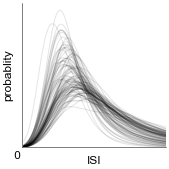

In [970]:
fig = plt.figure(figsize=(2, 2))
fig.set_facecolor('white')

widths = [1]
heights = [1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.0, 
                        left=0.0, right=1.0)

ax = fig.add_subplot(spec[0, 0])
ax.plot(cisi_t_eval, ISI_densities[:, 0, :].T, c='k', alpha=0.1)

ax.set_xlim([cisi_t_eval[0] - 0.03, cisi_t_eval[-1]])
ax.set_ylim(0)
ax.set_xticks([])
ax.set_yticks([])
ax.text(-0.15, -0.15, r'$0$', fontsize=11)

ax.set_xlabel('ISI')
ax.set_ylabel('probablity')

plt.show()

In [227]:
import plot_baselines

jitter = 1e-5
filters_dict = plot_baselines.spike_history_filters(rng, prng_state, jitter, array_type)

dt = 0.001
data_dict = plot_baselines.rate_rescaling(rng, dt, p = 0.003, ts = 3000)


time_t = data_dict['time']
rtime_t = data_dict['rescaled_time']
rates_t = data_dict['rates']
spike_times = data_dict["spike_times"]
rspike_times = data_dict["rescaled_spike_times"]

In [228]:
a, c = 6., 30.
phi_lower, phi_upper = a * np.log(c) - np.pi, (a * np.log(500 + c) + np.pi) * 0.87
print(phi_lower, phi_upper)

17.26559163638314 35.47760358279412


In [237]:
spike_times

array([ 424,  427, 1229, 1747, 1931, 2014, 2235, 2275])

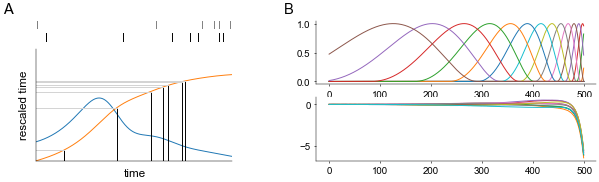

In [245]:
fig = plt.figure(figsize=(8, 2))
fig.text(-0.05, 1.05, 'A', fontsize=15, ha='center')
fig.text(0.45, 1.05, 'B', fontsize=15, ha='center')


### rate rescaling ###
widths = [1]
heights = [1, 1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.85, 
                        left=0.0, right=0.35, hspace=0.4)

ax = fig.add_subplot(spec[1, 0])
for st in spike_times:
    ax.plot(np.ones(2)*st, [0, 1], c='k')
ax.axis('off')
ax.set_ylim([0, 1])
ax.set_xlim([spike_times[0]-100, spike_times[-1]+100])

ax = fig.add_subplot(spec[0, 0])
for st in rspike_times:   
    ax.plot(np.ones(2)*st, [0, 1], c='gray')
ax.axis('off')
ax.set_ylim([0, 1])
ax.set_xlim([rspike_times[0]-100, rspike_times[-1]+100])


widths = [1]
heights = [1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=0.8, bottom=0.0, 
                        left=0.0, right=0.35, wspace=0.1)

ax = fig.add_subplot(spec[0, 0])

ax.plot(time_t, rates_t)
ax.plot(time_t, rtime_t)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('time')
ax.set_ylabel('rescaled time')

ax.set_xlim([time_t[0], time_t[-1]])
ax.set_ylim([rtime_t[0], 1.3*rtime_t[-1]])
for st, rst in zip(spike_times, rspike_times):
    ax.plot(np.ones(2)*st*dt, [0., rtime_t[st]], c='k')
    ax.plot([0., time_t[st]], np.ones(2)*rst*dt, c='lightgray')
    


### filters ###
widths = [1]
heights = [1, 1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.0, 
                        left=0.5, right=1., wspace=0.1)

ax = fig.add_subplot(spec[0, 0])

filter_t = filters_dict["glm_filter"]
t = np.arange(filter_t.shape[0])
ax.plot(t, filter_t[:, :, 0])


ax = fig.add_subplot(spec[1, 0])

filter_t = filters_dict["gp_filter"]
t = np.arange(filter_t.shape[1])

tr = 2
ax.plot(t, filter_t[:, :, 1, 0].T)



plt.savefig('../saves/baselines.pdf')
plt.show()

### Schematic of model

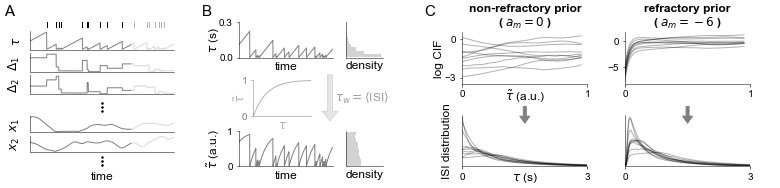

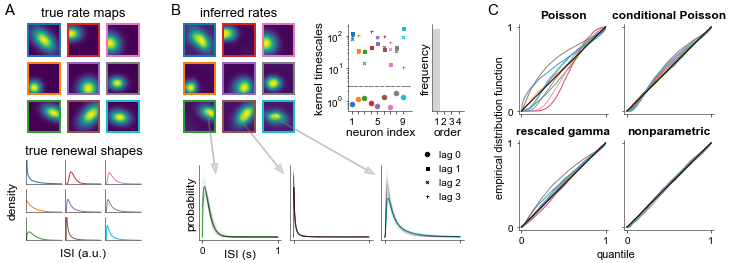

In [ ]:
fig = plt.figure(figsize=(8, 3))


### baseline rate maps ###


### ARD failure ###

## th1

In [866]:
datadir = '../saves/'
name = 'results_th1'

results = pickle.load(
    open(datadir + name + ".p", "rb")
)


regression_dict = results["regression"]
tuning_dict = results["tuning"]
variability_dict = results["variability"]

reg_config_names = list(regression_dict.keys())


eval_locs = tuning_dict["hd_x_locs"]

rEsamples = 1 / tuning_dict["hd_mean_ISI"]
percentiles = lib.utils.stats.percentiles_from_samples(
    rEsamples, percentiles=[0.05, 0.5, 0.95])

sm_filter = np.ones(5) / 5
padding_modes = ['periodic']
rElower, rEmedian, rEupper = [
    lib.utils.stats.smooth_histogram(p, sm_filter, padding_modes) for p in percentiles
]

Ersamples = tuning_dict["hd_mean_invISI"]
percentiles = lib.utils.stats.percentiles_from_samples(
    Ersamples, percentiles=[0.05, 0.5, 0.95])

sm_filter = np.ones(5) / 5
padding_modes = ['periodic']
Erlower, Ermedian, Erupper = [
    lib.utils.stats.smooth_histogram(p, sm_filter, padding_modes) for p in percentiles
]


cvsamples = tuning_dict["hd_CV_ISI"]
percentiles = lib.utils.stats.percentiles_from_samples(
    cvsamples, percentiles=[0.05, 0.5, 0.95])

sm_filter = np.ones(5) / 5
padding_modes = ['periodic']
cvlower, cvmedian, cvupper = [
    lib.utils.stats.smooth_histogram(p, sm_filter, padding_modes) for p in percentiles
]




imISI = 1 / variability_dict["mean_ISI"].mean(0)
#imISI = variability_dict["mean_invISI"].mean(0)
cvISI = variability_dict["CV_ISI"].mean(0)



warp_tau = tuning_dict['warp_tau']
len_tau = tuning_dict['len_tau']
len_deltas = tuning_dict['len_deltas']

ARD_order = []
for n in range(len_deltas.shape[0]):
    ARD_order.append(np.sum(len_deltas[n] < 3.) + 1)
    
    
plot_units = [3, 20, 27]

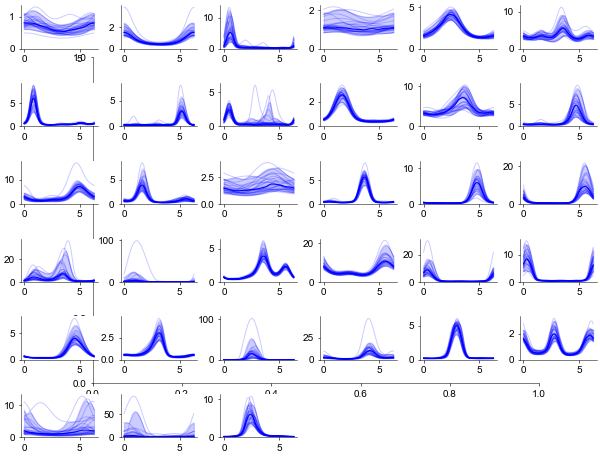

In [370]:
fig, ax = plt.subplots(figsize=(8, 6))
fig.set_facecolor('white')

W, H = 6, 6
widths = [1] * W
heights = [1] * H

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.0, 
                        left=0.0, right=1.0, wspace=0.3, hspace=0.8)

for n in range(W):
    for m in range(H):
        ne = m + n*W
        if ne >= rmedian.shape[0]:
            continue

        ax = fig.add_subplot(spec[n, m])
        line, = ax.plot(eval_locs[:, 0], rmedian[ne, :], 'b', label='posterior mean')
        ax.fill_between(eval_locs[:, 0], rlower[ne, :], rupper[ne, :], 
                        color=line.get_color(), alpha=0.2, label='95% confidence')
        ax.plot(eval_locs[:, 0], rsamples[:, ne, :].T, 'b', alpha=0.2)
        ax.set_ylim(0)

plt.savefig('invEtau.png', dpi=60)
plt.show()

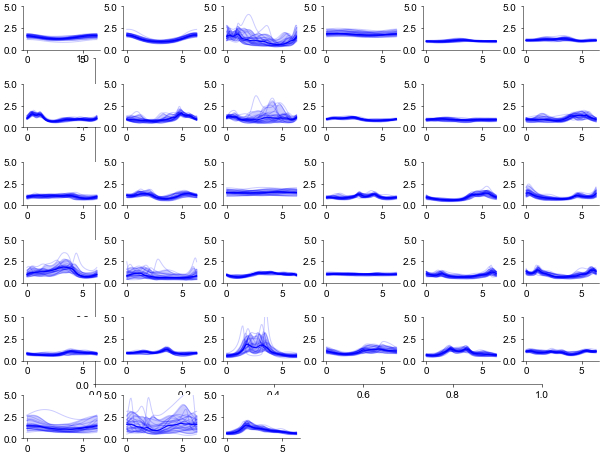

In [357]:
fig, ax = plt.subplots(figsize=(8, 6))


W, H = 6, 6
widths = [1] * W
heights = [1] * H

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.0, 
                        left=0.0, right=1.0, wspace=0.3, hspace=0.8)

for n in range(W):
    for m in range(H):
        ne = m + n*W
        if ne >= cvmedian.shape[0]:
            continue

        ax = fig.add_subplot(spec[n, m])
        line, = ax.plot(eval_locs[:, 0], cvmedian[ne, :], 'b', label='posterior mean')
        ax.fill_between(eval_locs[:, 0], cvlower[ne, :], cvupper[ne, :], 
                        color=line.get_color(), alpha=0.2, label='95% confidence')
        ax.plot(eval_locs[:, 0], cvsamples[:, ne, :].T, 'b', alpha=0.2)
        ax.set_ylim([0, 5])

plt.show()

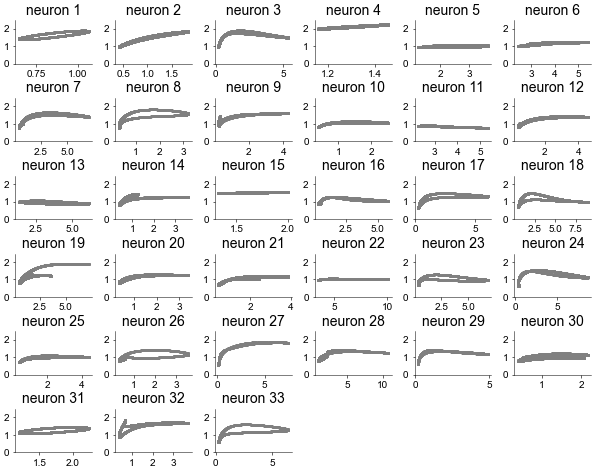

In [868]:
fig = plt.figure(figsize=(8, 6))

#fig.text(0.22, 1.05, 'repeatable trials', fontsize=12, ha='center')
#fig.text(0.78, 1.05, 'naturalistic behaviour', fontsize=12, ha='center')


### moment-by-moment ###
W, H = 6, 6
widths = [1] * W
heights = [1] * H

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.0, 
                        left=0.0, right=1.0, wspace=0.3, hspace=0.8)

for n in range(W):
    for m in range(H):
        ne = m + n*W
        if ne >= imISI.shape[0]:
            continue
            
        ax = fig.add_subplot(spec[n, m])
        ax.set_title('neuron {}'.format(ne + 1))
        ax.scatter(imISI[ne], cvISI[ne], marker='.', c='gray', s=4)
        ax.set_ylim([0, cvISI.max() * 1.1])
        ax.set_yticks([0, 1, 2])
        
plt.show()

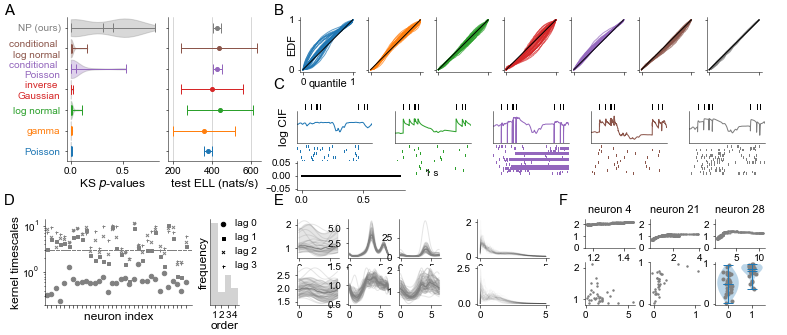

In [890]:
fig = plt.figure(figsize=(10, 4))
fig.set_facecolor('white')



cs = [
    'tab:blue',
    'tab:orange', 
    'tab:green',
    'tab:red',
    'tab:purple',
    'tab:brown',
    'tab:gray',
]
use_model_inds = np.array([0, 1, 2, 3, 4, 5, 9])
use_reg_config_names = [reg_config_names[k] for k in use_model_inds]
use_names = [
    'Poisson', 
    'gamma', 
    'log normal', 
    'inverse \nGaussian', 
    'conditional \nPoisson', 
    'conditional \nlog normal', 
    'NP (ours)', 
]
visualize_inds = [0, 2, 4, 5, 6]
visualize_names = [reg_config_names[k] for k in use_model_inds[visualize_inds]]
    
    
fig.text(-0.05, 1.01, 'A', fontsize=15, ha='center')
plot_fit_stats(fig)

fig.text(0.325, 1.01, 'B', fontsize=15, ha='center')
plot_QQ(fig)

fig.text(0.325, 0.75, 'C', fontsize=15, ha='center')
plot_posteriors(fig)

fig.text(-0.05, 0.35, 'D', fontsize=15, ha='center')
plot_kernel_lens(fig)

fig.text(0.325, 0.35, 'E', fontsize=15, ha='center')
plot_instantaneous(fig)

fig.text(0.72, 0.35, 'F', fontsize=15, ha='center')
plot_th1_tuning(fig)

fig.text(1.02, 1.01, 'S', fontsize=15, alpha=0., ha='center')  # space


    

#plt.savefig('../saves/th1.pdf')
plt.show()

<ErrorbarContainer object of 3 artists>

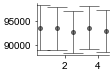

In [280]:
fig = plt.figure(figsize=(10, 4))

#fig.text(0.22, 1.05, 'repeatable trials', fontsize=12, ha='center')
#fig.text(0.78, 1.05, 'naturalistic behaviour', fontsize=12, ha='center')


### compare different BNPPs th1 ###
widths = [1]
heights = [1, 1]

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.6, 
                        left=0.0, right=0.1, wspace=0.1)


use_reg_config_names = [reg_config_names[k] for k in [4, 6, 7, 8, 9]]

mdls = len(use_reg_config_names)
test_lls = np.array([regression_dict[n]['test_ells'] for n in use_reg_config_names])
train_lls = np.array([regression_dict[n]['train_ell'] for n in use_reg_config_names])

ax = fig.add_subplot(spec[0, 0])
means = test_lls.mean(-1)
sems = test_lls.std(-1) / np.sqrt(test_lls.shape[-1])
ax.errorbar(
    .5 + np.arange(mdls), means, yerr=sems, 
    alpha=0.5, color='black', capsize=10, linestyle='', 
    marker='o', markersize=4,
)



### compare different BNPPs hc3 ###

## hc3

In [846]:
datadir = '../saves/'
name = 'results_hc3'

results = pickle.load(
    open(datadir + name + ".p", "rb")
)




regression_dict = results["regression"]
tuning_dict = results["tuning"]
variability_dict = results["variability"]

reg_config_names = list(regression_dict.keys())


pos_invEisi = 1/tuning_dict["xtLR_mean_ISI"].mean(0)
pos_Einvisi = tuning_dict["xtLR_mean_invISI"].mean(0)
pos_CV = tuning_dict["xtLR_CV_ISI"].mean(0)



imISI = 1 / variability_dict["mean_ISI"].mean(0)
#imISI = variability_dict["mean_invISI"].mean(0)
cvISI = variability_dict["CV_ISI"].mean(0)


warp_tau = tuning_dict['warp_tau']
len_tau = tuning_dict['len_tau']
len_deltas = tuning_dict['len_deltas']


ARD_order = []
for n in range(len_deltas.shape[0]):
    ARD_order.append(np.sum(len_deltas[n] < 3.) + 1)
    
    
plot_units = [3, 20, 27]

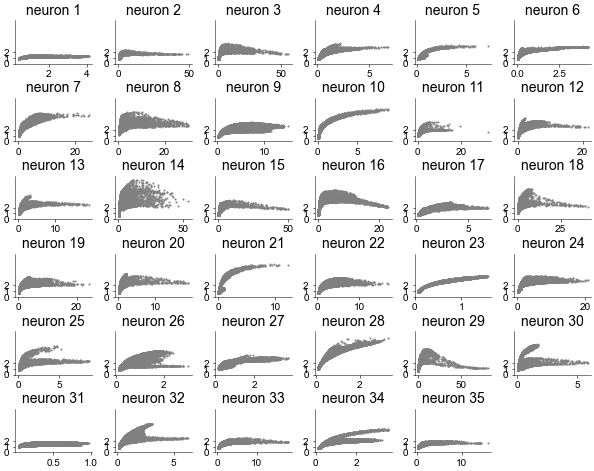

In [273]:
fig = plt.figure(figsize=(8, 6))

#fig.text(0.22, 1.05, 'repeatable trials', fontsize=12, ha='center')
#fig.text(0.78, 1.05, 'naturalistic behaviour', fontsize=12, ha='center')


### moment-by-moment ###
W, H = 6, 6
widths = [1] * W
heights = [1] * H

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.0, 
                        left=0.0, right=1.0, wspace=0.3, hspace=0.8)

for n in range(W):
    for m in range(H):
        ne = m + n*W
        if ne >= imISI.shape[0]:
            continue
            
        ax = fig.add_subplot(spec[n, m])
        ax.set_title('neuron {}'.format(ne + 1))
        ax.scatter(imISI[ne], cvISI[ne], marker='.', c='gray', s=4)
        ax.set_ylim([0, cvISI.max() * 1.1])
        ax.set_yticks([0, 1, 2])
        
plt.show()

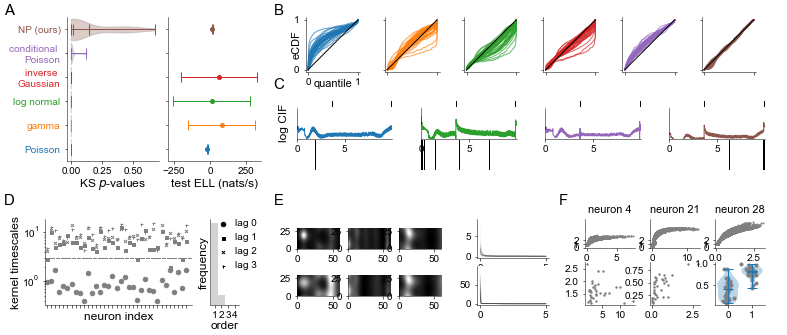

In [851]:
fig = plt.figure(figsize=(10, 4))
fig.set_facecolor('white')



cs = [
    'tab:blue',
    'tab:orange', 
    'tab:green',
    'tab:red',
    'tab:purple',
    'tab:brown',
    'tab:pink',
    'tab:gray',
]
use_model_inds = np.array([0, 1, 2, 3, 4, 6])
use_reg_config_names = [reg_config_names[k] for k in use_model_inds]
use_names = [
    'Poisson', 
    'gamma', 
    'log normal', 
    'inverse \nGaussian', 
    'conditional \nPoisson', 
 #   'conditional \nlog normal', 
    'NP (ours)', 
]
visualize_inds = [0, 2, 4, 5]
visualize_names = [reg_config_names[k] for k in use_model_inds[visualize_inds]]
        
    

fig.text(-0.05, 1.01, 'A', fontsize=15, ha='center')
plot_fit_stats(fig)

fig.text(0.325, 1.01, 'B', fontsize=15, ha='center')
plot_QQ(fig)

fig.text(0.325, 0.75, 'C', fontsize=15, ha='center')
plot_posteriors(fig)

fig.text(-0.05, 0.35, 'D', fontsize=15, ha='center')
plot_kernel_lens(fig)

fig.text(0.325, 0.35, 'E', fontsize=15, ha='center')
plot_instantaneous(fig)

fig.text(0.72, 0.35, 'F', fontsize=15, ha='center')
plot_hc3_tuning(fig)

fig.text(1.02, 1.01, 'S', fontsize=15, alpha=0., ha='center')  # space

    

#plt.savefig('../saves/hc3.pdf')
plt.show()

In [83]:
def get_renewal(renewal_type, neurons, dt):
    if renewal_type == 'gamma':
        alpha = np.linspace(0.2, 100.5, neurons)
        renewal = lib.likelihoods.GammaRenewal(
            neurons,
            dt,
            alpha,
        )

    elif renewal_type == 'lognorm':
        sigma = np.linspace(0.5, 1.5, neurons)
        renewal = lib.likelihoods.LogNormalRenewal(
            neurons,
            dt,
            sigma,
        )

    elif renewal_type == 'invgauss':
        mu = np.linspace(1.0, 1.5, neurons)
        renewal = lib.likelihoods.InverseGaussianRenewal(
            neurons,
            dt,
            mu,
        )
        
    elif renewal_type == 'exponential':
        renewal = lib.likelihoods.ExponentialRenewal(
            neurons,
            dt,
        )
    
    return renewal

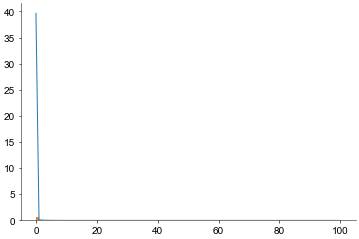

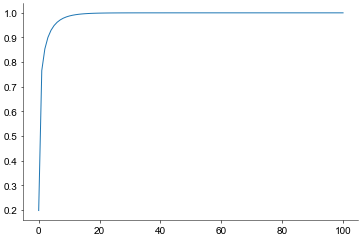

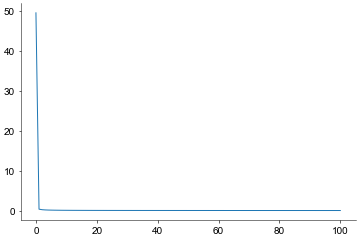

In [84]:
dt = 0.001
rm = get_renewal('gamma', 1, dt)

mc = 1000
samples = jax.vmap(rm.sample_ISI)(jr.split(prng_state, mc))


ISI = jnp.linspace(0.001, 100., 100)[:, None]

ll = jax.vmap(rm.log_density)(ISI)
plt.plot(ISI, np.exp(ll)[:, :])
plt.hist(np.array(samples)[:, -1], bins=np.array(ISI)[:, 0], density=True)
plt.show()

cd = jax.vmap(rm.cum_density)(ISI)
plt.plot(ISI, cd[:, :])
plt.show()

lh = jax.vmap(rm.log_hazard)(ISI)
plt.plot(ISI, jnp.exp(lh[:, :]))
plt.show()

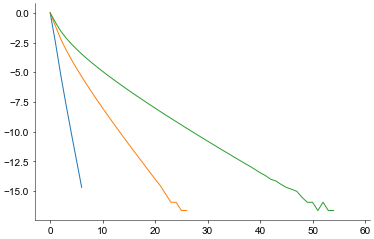

In [77]:
from tensorflow_probability.substrates import jax as tfp

igd = tfp.distributions.InverseGaussian(jnp.linspace(0.5, 1.5, 3), jnp.ones(3))

t = jnp.linspace(0.001, 100., 100)[:, None]
lh = igd.log_survival_function(t)

plt.plot((lh[:, :]))
plt.show()